# Service Components

***
* Downloaded service-components data from the "market analysis" view. 
* Re-do initial analysis with this new data.
* "Components" column  reflects what the organizations <b>actually</b> use a particular product for.
    * Renamed to "components_orgs_actually_use" to make this a little clearer.

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 64
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from collections import Counter, OrderedDict
from itertools import chain
from os import path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from calitp import *
from IPython.display import HTML, Image, Markdown, display, display_html
from PIL import Image
from shared_utils import altair_utils
from siuba import *

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/transit_stacks/"

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
service_components = to_snakecase(
    pd.read_csv(f"{GCS_FILE_PATH}service-components-Market Analysis.csv")
)

In [3]:
f"{len(service_components)} rows"

'1032 rows'

In [4]:
service_components.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   name                                              1032 non-null   object
 1   services                                          1027 non-null   object
 2   component                                         1030 non-null   object
 3   vendor__from_product_                             950 non-null    object
 4   parent_organization__from_vendor___from_product_  247 non-null    object
 5   provider__from_services_                          1027 non-null   object
 6   product                                           1030 non-null   object
 7   product_components                                973 non-null    object
dtypes: object(8)
memory usage: 64.6+ KB


In [5]:
# Fill in N/A and rename cols to be a little clearer.
service_components = service_components.fillna("N/A").rename(
    columns={
        "component": "components_orgs_actually_use",
        "product_components": "all_components_in_product",
    }
)

In [6]:
# Drop Duplicates
service_components = service_components.drop_duplicates()

In [7]:
display(
    Markdown(
        f"The length of the dataframe went down to {len(service_components)} after dropping duplicates"
        "<br>"
        f"There are {service_components.services.nunique()} different organizations."
        "<br>"
        f" There are {service_components.components_orgs_actually_use.nunique()} different components."
    )
)

The length of the dataframe went down to 1023 after dropping duplicates<br>There are 156 different organizations.<br> There are 26 different components.

In [8]:
# Copy dataframe to not mess the original one.
service_components2 = service_components.copy()

In [9]:
# Find if a value in "components_usage" matches a value in "all components in product" column because sometimes, they don't match?
# If there is at least one match, tag as "True."

# https://stackoverflow.com/questions/21514191/check-if-pandas-column-contains-value-from-another-column
service_components2["contained"] = service_components2.apply(
    lambda x: x.components_orgs_actually_use in x.all_components_in_product, axis=1
)

In [10]:
# De duplicate provider from services & remove unnecessary quotation marks
# https://stackoverflow.com/questions/56466917/is-there-a-way-in-pandas-to-remove-duplicates-from-within-a-series
service_components2["provider__from_services_"] = (
    service_components2["provider__from_services_"]
    .apply(lambda x: ", ".join(set([y.strip() for y in x.split(",")])))
    .str.strip()
    .replace({'"': ""}, regex=True)
)

In [11]:
# Some of the de  duplicating left things like "Davis, University of California Davis." So grab only second element behind the comma, if there is a comma.
service_components2["provider__from_services_"] = (
    service_components2["provider__from_services_"].str.rsplit(",").str[-1]
)

In [12]:
# Double check that this worked properly.
service_components2[
    [
        "services",
        "provider__from_services_",
        "product",
        "components_orgs_actually_use",
        "all_components_in_product",
        "contained",
    ]
].sample(3)

,services,provider__from_services_,product,components_orgs_actually_use,all_components_in_product,contained
754,"Muni Bus,Muni Metro,San Francisco Cable Cars,Market Street Historic Railway",City and County of San Francisco,"Moovel Mobile Ticketing,Cubic Clipper",Mobile ticketing,"Mobile ticketing,Fare card system",True
1026,"OmniTrans,OmniTrans sbX,OmniRide",OmniTrans,Transit Royale,Mobile trip planning app,"Mobile trip planning app,Alerts Subscription Service",True
957,Long Beach Transit,Long Beach Transit,Cubic - Unspecified,Ticket Vending Machines,"AVL On-board Computer,AVL Software,Location Sensors,Real-time info,Arrival predictions,Fare card system,Mobile ticketing,Contactless Payment Validators",False


In [13]:
# Count how many true and false.
service_components2.contained.value_counts()

False    548
True     475
Name: contained, dtype: int64

## Summarizing the DataFrame
***
* It looks like some services/organizations use the same product from the same vendor for 1+ components but this is split on 2 lines.
    * Example: Tuolumne County Transit uses Doublemap RealTime product for both real-time and arrival predictions. 
    * However, 'real-time' and 'arrival predictions' are split on  different lines, even though they reference the same product, vendor, and customer.
    * 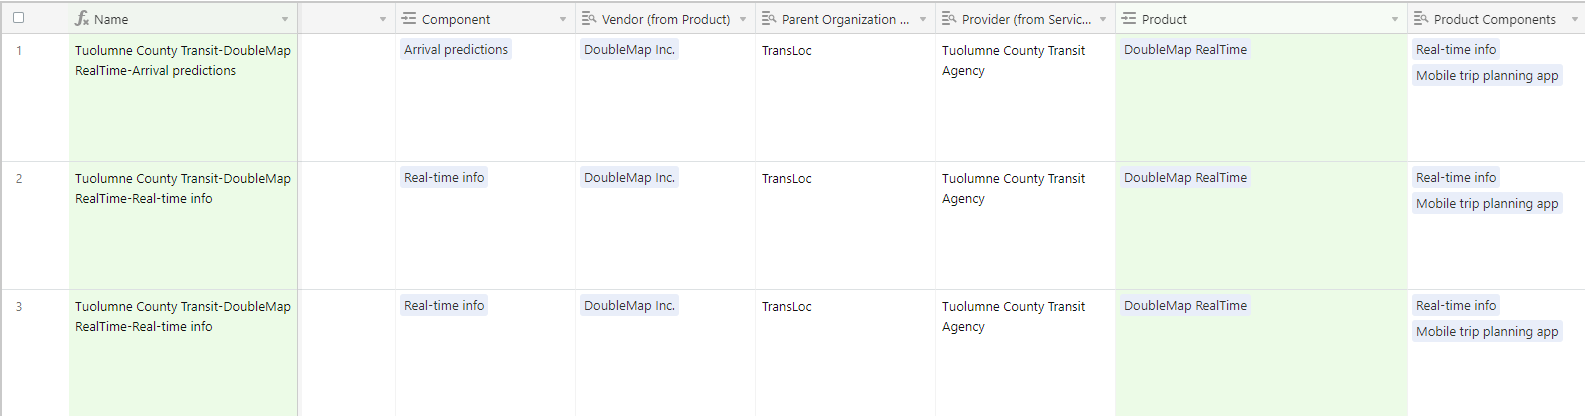
* Group/summarize so the same service-vendor-product combination on the same line to avoid duplicate entires.

In [14]:
# Copy dataframe to not mess the original one.
service_components3 = service_components2.copy()

In [15]:
# Group the column "components_orgs_actually_use" based on provider from services, vendor, and product
service_components3["components_usage"] = service_components3.groupby(
    ["provider__from_services_", "vendor__from_product_", "product"]
)["components_orgs_actually_use"].transform(lambda x: ",".join(x))

In [16]:
# Sort dataframe by the columns "product" and "contained". Thus, if a product-company-agency combination has at least one TRUE, we would capture it.
service_components3 = service_components3.sort_values(
    by=["product", "contained"], ascending=False
)

In [17]:
# Drop the  duplicates by sbuset
service_components3 = service_components3.drop_duplicates(
    subset=[
        "provider__from_services_",
        "product",
        "vendor__from_product_",
        "components_usage",
    ],
    keep="first",
)

In [18]:
# Keep only columns of interest
service_components3 = service_components3[
    [
        "services",
        "vendor__from_product_",
        "provider__from_services_",
        "parent_organization__from_vendor___from_product_",
        "product",
        "all_components_in_product",
        "components_usage",
        "contained",
    ]
]

In [19]:
# Double checking
service_components3[
    (service_components3.services.str.contains("GET Bus,GET Bus On Demand", case=False))
]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained
35,"GET Bus,GET Bus On Demand",Worldpay,Golden Empire Transit District,Fidelity National Information Services,Worldpay,Payment processor,Payment processor,True
2,"GET Bus,GET Bus On Demand",UTA,Golden Empire Transit District,N/A,UTA APC Software,APC Software,APC Software,True
58,"GET Bus,GET Bus On Demand",Transit App Inc.,Golden Empire Transit District,N/A,Transit App,Mobile trip planning app,Alerts Content Management System,False
8,"GET Bus,GET Bus On Demand",TransTrack Solutions Group,Golden Empire Transit District,N/A,TransTrack Manager,"Data Analysis/GIS/Modelling Software,KPI Reporting","KPI Reporting,KPI Reporting",True
1,"GET Bus,GET Bus On Demand",Token Transit,Golden Empire Transit District,N/A,Token Transit Mobile Ticketing,Mobile ticketing,Mobile ticketing,True
96,"GET Bus,GET Bus On Demand",SunriseSESA,Golden Empire Transit District,N/A,Sunrise CDP,"General Signage ,Interior signage,Headsigns,Side signs",Offboard signage,False
17,"GET Bus,GET Bus On Demand",Optibus,Golden Empire Transit District,N/A,Optibus,"Scheduling (Fixed-route),GTFS Schedule Publishing,GTFS generation",Scheduling (Fixed-route),True
24,"GET Bus,GET Bus On Demand",Hanover Displays Ltd,Golden Empire Transit District,N/A,Hanover Headsigns,Headsigns,Headsigns,True
0,"GET Bus,GET Bus On Demand",Genfare,Golden Empire Transit District,N/A,Genfare Farebox (Unspecified),Cash Farebox,Cash Farebox,True
3,"GET Bus,GET Bus On Demand",Connexionz Inc.,Golden Empire Transit District,N/A,Connextionz Vehicle and Shelter Displays,Offboard signage,Interior signage,False


In [20]:
len(service_components3)

699

In [21]:
service_components3.contained.value_counts()

True     437
False    262
Name: contained, dtype: int64

In [ ]:
# Change Uber Inc.
service_components3["vendor__from_product_"] = service_components3[
    "vendor__from_product_"
].replace({"Uber Inc.,Uber Inc.": "Uber Inc."})

## Are there vendors that offer GTFS & Real Time that nobody is using?
***

* No. There are even more vendors in the service component dataset compared to the products data set.

In [22]:
# Filter out products that have GTFS and Scheduling in service components dataset
gtfs_rt = service_components[
    service_components["all_components_in_product"].str.contains("GTFS", case=False)
    & service_components["all_components_in_product"].str.contains(
        "real-time", case=False
    )
]

In [23]:
# Double check
# gtfs_rt

In [24]:
# Read in products data set
FILE_NAME = "transit_stacks.xlsx"
products = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="products_clean")

In [25]:
# Filter out products that have GTFS and Scheduling in products dataset
products_gtfs_rt = products[
    products["components"].str.contains("GTFS", case=False)
    & products["components"].str.contains("real-time", case=False)
]

In [26]:
# Grab unique vendors and change it to a set for PRODUCTS table.
products_vendors = set(products_gtfs_rt.vendor.unique().tolist())
products_vendors

{'GMV Syncromatics Inc', 'Swiftly Inc.', 'TripShot Inc.', 'Uber Inc.'}

In [27]:
# Grab unique vendors and change it to a set for SERVICE COMPONENTS table.
service_comps_vendors = set(gtfs_rt.vendor__from_product_.unique().tolist())
service_comps_vendors

{'DoubleMap Inc.,Nixle',
 'GMV Syncromatics Inc',
 'Optibus,GMV Syncromatics Inc',
 'Swiftly Inc.',
 'Token Transit,Uber Inc.',
 'TripShot Inc.',
 'Uber Inc.',
 'Uber Inc.,Uber Inc.'}

In [28]:
# Look at the set
products_vendors - service_comps_vendors

set()

## How many components are organizations <i>actually</i> using vs. how many components a product actually offers?
***


In [29]:
# Number of components an organization uses that product for 
# Count number of values by commas
# https://stackoverflow.com/questions/30202011/how-can-i-count-comma-separated-values-in-one-column-of-my-panda-table
service_components3["number_of_components_used"] = (
    service_components3["components_usage"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)
# Number of components available in the product
service_components3["number_of_components_avail"] = (
    service_components3["all_components_in_product"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)

In [30]:
service_components3.head(1)

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained,number_of_components_used,number_of_components_avail
870,"Monterey-Salinas Transit,MST Monterey Trolley",N/A,Monterey-Salinas Transit,N/A,"authorize.net,Transax","Merchant services,Payment processor,Merchant services",Payment processor,True,1,3


In [31]:
# Double checking
service_components3[
    [
        "product",
        "provider__from_services_",
        "all_components_in_product",
        "number_of_components_avail",
        "components_usage",
        "number_of_components_used",
    ]
].sample(4)

,product,provider__from_services_,all_components_in_product,number_of_components_avail,components_usage,number_of_components_used
851,Genfare Farebox (Unspecified),Sonoma County,Cash Farebox,1,Cash Farebox,1
934,Diamond - Cash box,Palo Verde Valley Transit Agency,Cash Farebox,1,Cash Farebox,1
102,Passio Go!,City of Cerritos,Real-time info,1,Real-time info,1
683,Connextionz Vehicle and Shelter Displays,Eastern Contra Costa Transit Authority,Offboard signage,1,Interior signage,1


### Find mean of components available across all products
***

In [32]:
# Subset of original df
avail_components = service_components3[
    [
        "vendor__from_product_",
        "product",
        "all_components_in_product",
        "components_usage",
        "number_of_components_used",
        "number_of_components_avail",
    ]
]

In [33]:
# Drop duplicates, we only want one row per product-vendor-component combo
avail_components = avail_components.drop_duplicates(
    ["vendor__from_product_", "product", "all_components_in_product"]
)

In [34]:
avail_components['product'].nunique()

207

In [35]:
avail_components["number_of_components_avail"].mean()

2.42512077294686

In [36]:
avail_components.number_of_components_avail.value_counts()

1     94
2     47
3     22
4     15
5     10
6      9
8      4
10     2
7      2
9      2
Name: number_of_components_avail, dtype: int64

In [37]:
service_components3[service_components3["number_of_components_used"] == 13]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained,number_of_components_used,number_of_components_avail
52,"Unitrans,UC Davis Health MedTrans",Cubic,Davis,N/A,Cubic NextBus Suite,Real-time info,"Alerts Content Management System,APC Software,Mobile data terminal software,Arrival predictions,AVL Software,Offboard signage,Real-time info,Arrival predictions,AVL Software,Alerts Content Management System,Mobile data terminal software,Offboard signage,APC Software",True,13,1


In [38]:
# Group to by how many components available versus how many components are actually being used. Count organizations - unique.
components_used = (
    service_components3.groupby(
        ["number_of_components_avail", "number_of_components_used"]
    )
    .agg({"provider__from_services_": "nunique"})
    .rename(columns={"provider__from_services_": "Count of Organizations"})
)

In [39]:
# Rename index
components_used.index.names = ["# of Components Available", "# of Components Used"]

* Most organizations (105) use a product with only one component available anyway.
* The next most common combination: 2 components are available for a product, but only 1 product is used.
* There are some crazy skews.
* For example: Placer County uses Cubic Next Suite for 8 different task but Cubic Next Suite has 1 component listed - hence the crazy skew.
* 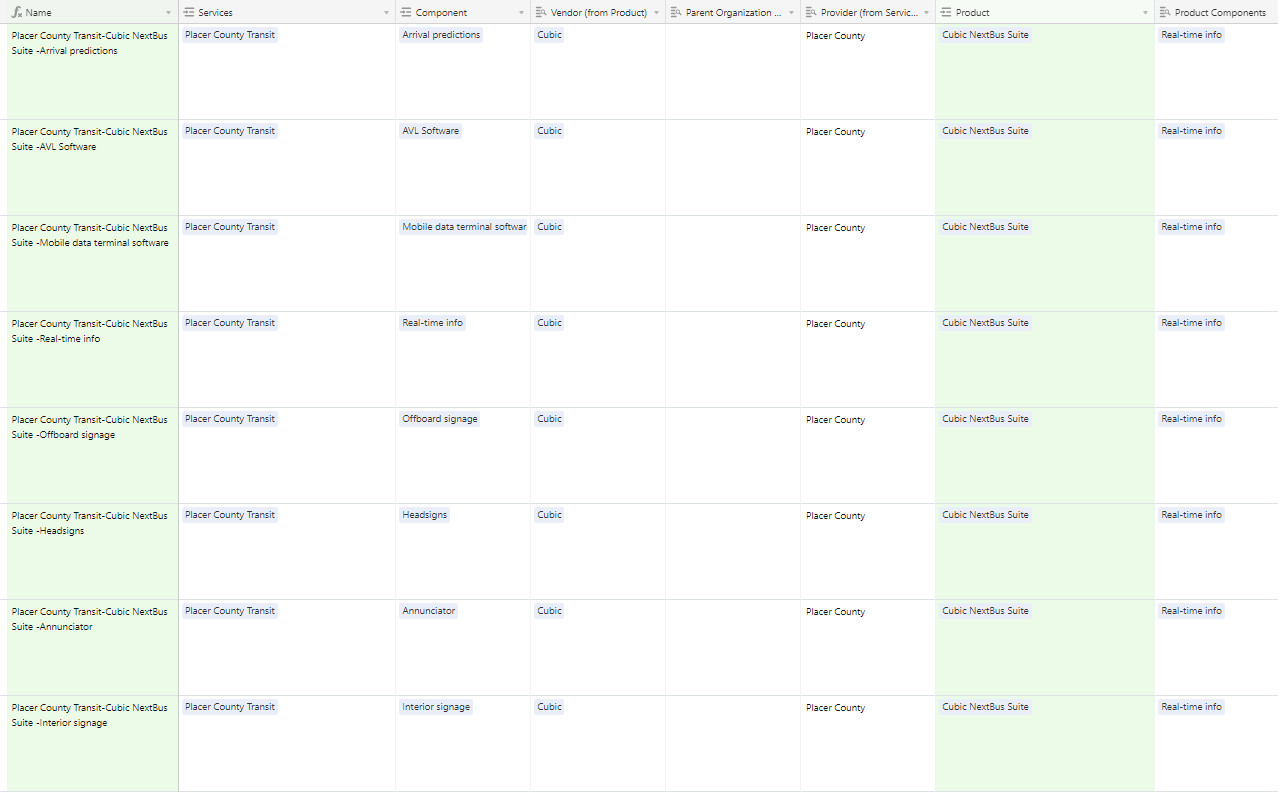

In [40]:
components_used.style.set_properties(**{"background-color": "white"}).bar(
    subset=["Count of Organizations"], color="#2EA8CE"
)

In [41]:
components_used.reset_index()

,# of Components Available,# of Components Used,Count of Organizations
0,1,1,101
1,1,2,30
2,1,3,15
3,1,4,4
4,1,5,5
5,1,6,2
6,1,7,4
7,1,8,1
8,1,9,1
9,1,13,1


## Why are organizations only buying/using certain components but not others?
***
* Using "function group" in components dataset to see if there are particular categories where organizations are only buying certain components.
* Only look at products with more than one component available. 


In [42]:
# Read in components data set
FILE_NAME = "transit_stacks.xlsx"
components = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="components_clean")

In [43]:
# Keep only certain columns
components = components[["name", "function_group", "products"]].copy()

In [44]:
components["function_group"] = components["function_group"].replace(
    {"Rider info": "Rider Info"}
)

In [45]:
components.head(2)

,name,function_group,products
0,Advertising Agency,NaN,Intersection
1,Alerts Content Management System,Rider Info,"IBI Alerts,RouteShout,RouteMatch - Demand: Notifications Module,Trillium Trip Alerts,Swiftly Transitime,Nixle Engage"


In [46]:
# Explode the dataframe - take out all the values in products split by comma and put each value in its own row
# https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
components2 = (
    components.set_index(["name", "function_group"])
    .apply(lambda x: x.str.split(",").explode())
    .reset_index()
)

In [47]:
components2.head()

,name,function_group,products
0,Advertising Agency,NaN,Intersection
1,Alerts Content Management System,Rider Info,IBI Alerts
2,Alerts Content Management System,Rider Info,RouteShout
3,Alerts Content Management System,Rider Info,RouteMatch - Demand: Notifications Module
4,Alerts Content Management System,Rider Info,Trillium Trip Alerts


In [48]:
# Merge on the right
merge3 = pd.merge(
    components2,
    service_components3,
    left_on="products",
    right_on="product",
    indicator=True,
    how="outer",
)

In [49]:
merge4 = merge3.drop_duplicates()

In [50]:
merge4._merge.value_counts()

both          1100
left_only      196
right_only      96
Name: _merge, dtype: int64

In [51]:
# Filter out for merge only "both" and products with more than 1 component available.
merge4 = merge4[
    (merge4["_merge"] == "both") & (merge4["number_of_components_avail"] > 1)
]

In [52]:
merge4 = merge4[
    [
        "function_group",
        "product",
        "vendor__from_product_",
        "services",
        "parent_organization__from_vendor___from_product_",
        "number_of_components_used",
        "number_of_components_avail",
    ]
].copy()

In [53]:
# Not sure why there are STILL tons of duplicates even tho I dropped them a few cells up. Dropping them again
merge4 = merge4.drop_duplicates()

In [54]:
merge4.sample(3)

,function_group,product,vendor__from_product_,services,parent_organization__from_vendor___from_product_,number_of_components_used,number_of_components_avail
811,Operations,ISC Applied Systems (Unspecified Model),ISC Applied Systems,Sonoma-Marin Area Rail Transit,N/A,1.00,2.00
649,Backoffice,RoadSoft Software Suite,Michigan Technological University Center for Technology and Training,Santa Ynez Valley Transit,N/A,1.00,2.00
923,Rider Info,Giro HASTUS,Giro Inc.,"SamTrans,SamTrans Shuttles",N/A,2.00,2.00


In [55]:
len(merge4)

362

In [56]:
# Group by function group for mean of components available and mean of components used
function_summary = (
    merge4.groupby(["function_group"])
    .agg({"number_of_components_avail": "mean", "number_of_components_used": "mean"})
    .reset_index()
)

In [57]:
#Get the ratio
function_summary["Ratio of Components Available vs Used"] = (
    function_summary["number_of_components_avail"]
    / function_summary["number_of_components_used"]
).round(1)

In [58]:
function_summary = function_summary.rename(
    columns={
        "function_group": "Function",
        "number_of_components_avail": "Average # of Components for Products with 1+ Components",
        "number_of_components_used": "Average # of Components Used",
    }
)

* Attempting to see if there's anything interesting by the 7 choices in Function instead of using components, which has 26 different groups. 


In [59]:
function_summary.sort_values("Average # of Components for Products with 1+ Components")

,Function,Average # of Components for Products with 1+ Components,Average # of Components Used,Ratio of Components Available vs Used
2,IT,2.00,1.00,2.00
6,Scheduling,2.52,1.74,1.50
0,Backoffice,2.96,1.57,1.90
5,Rider Info,3.12,1.51,2.10
1,Fare collection,4.45,2.25,2.00
3,Operations,4.88,1.73,2.80
4,Reporting,5.05,1.95,2.60


In [60]:
utils.basic_bar_chart(
    function_summary,
    "Ratio of Components Available vs Used",
    "Function",
    "Function",
    "Ratio of Components Available vs Components Used",
)

alt.Chart(...)

## Which components are organizations "buying twice" theoretically?
***

* Products can have multiple functions.
* Organizations buy multiple products and these products they buy potentially have the same components.
* See which components are appear more than once in the various products an organization has purchased.

Draft findings:
* 34 different organizations bought more than 1 product with real-time capabilities.
* 11 " " with offboard signage capabilities.
* 9 " " with scheduling (fixed-route) feature.

In [61]:
service_components3[service_components3["provider__from_services_"] == "OmniTrans"]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained,number_of_components_used,number_of_components_avail
672,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze Signage,General Signage,"Headsigns,Interior signage",False,2,1
140,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze Fixed Route Scheduling,"Run cutting,Driver Sign-up",Scheduling (Fixed-route),False,1,2
673,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze Annunciator,Annunciator,Annunciator,True,1,1
464,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze - Unspecified,"Scheduling (Fixed-route),GTFS generation","Mobile data terminal software,APC Software",False,2,2
1026,"OmniTrans,OmniTrans sbX,OmniRide",Transit App Inc.,OmniTrans,N/A,Transit Royale,"Mobile trip planning app,Alerts Subscription Service",Mobile trip planning app,True,1,2
896,"OmniTrans,OmniTrans sbX",TransTrack Solutions Group,OmniTrans,N/A,TransTrack Manager,"Data Analysis/GIS/Modelling Software,KPI Reporting",KPI Reporting,True,1,2
749,"OmniTrans,OmniTrans sbX",Token Transit,OmniTrans,N/A,Token Transit Mobile Ticketing,Mobile ticketing,Mobile ticketing,True,1,1
261,"OmniTrans,OmniTrans sbX",N/A,OmniTrans,N/A,In house activity,N/A,GTFS generation,False,1,1
842,"OmniTrans,OmniTrans sbX",Genfare,OmniTrans,N/A,Genfare Farebox (Unspecified),Cash Farebox,Cash Farebox,True,1,1
962,"OmniTrans,OmniTrans sbX",Genfare,OmniTrans,N/A,GenFare TVM (Unspecified),Ticket Vending Machines,Ticket Vending Machines,True,1,1


In [62]:
# Summarizing dataframe even more
# For each service/organization, place ALL the products used, all components in a product, and all the components a service uses on to one row.
services_products = (
    service_components3.groupby("provider__from_services_")["product"]
    .apply(",".join)
    .reset_index()
)

In [63]:
services_products.head(2)

,provider__from_services_,product
0,Berkeley,Cubic NextBus Suite
1,City of Fairfield,"Transit Royale,Cubic NextBus Suite"


In [64]:
services_components_in_products = (
    service_components3.groupby("provider__from_services_")["all_components_in_product"]
    .apply(",".join)
    .reset_index()
)

In [65]:
services_components_in_products.head(2)

,provider__from_services_,all_components_in_product
0,Berkeley,Real-time info
1,City of Fairfield,"Mobile trip planning app,Alerts Subscription Service,Real-time info"


In [66]:
services_components_used = (
    service_components3.groupby("provider__from_services_")["components_usage"]
    .apply(",".join)
    .reset_index()
)

In [67]:
services_components_used.head(2)

,provider__from_services_,components_usage
0,Berkeley,"Real-time info,Real-time info"
1,City of Fairfield,"Mobile trip planning app,Real-time info"


In [68]:
# Merge the dataframes together on provider__from_services_
merge1 = pd.merge(
    services_products, services_components_in_products, on="provider__from_services_"
)

In [69]:
merge1.head(1)

,provider__from_services_,product,all_components_in_product
0,Berkeley,Cubic NextBus Suite,Real-time info


In [70]:
services_components_used.head(1)

,provider__from_services_,components_usage
0,Berkeley,"Real-time info,Real-time info"


In [71]:
merge2 = pd.merge(
    merge1, services_components_used, on="provider__from_services_"
).rename(
    columns={
        "product": "products purchased",
        "all_components_in_product": "available components across all purchased products",
        "components_usage": "components used",
    }
)

In [72]:
# Double check that we have the same number of orgs in merge2 as our original df.
merge2.provider__from_services_.nunique()

120

In [73]:
# Just double checking
merge2.sample(2)

,provider__from_services_,products purchased,available components across all purchased products,components used
89,Redwood Coast Transit Authority,"Trillium GTFS Manager,Token Transit Mobile Ticketing,Excel,DoubleMap RealTime,DoubleMap (Unspecified Model),Diamond - Cash box","GTFS generation,GTFS Schedule Publishing,Mobile ticketing,General Purpose Software,Real-time info,Mobile trip planning app,Real-time info,Cash Farebox","GTFS generation,Mobile ticketing,Scheduling (Fixed-route),Arrival predictions,Alerts Content Management System,Real-time info,AVL Software,Mobile data terminal software,Offboard signage,Cash Farebox"
29,City of Huntington Park,Cashbox,Cash Farebox,Cash Farebox


In [74]:
# Count frequency of components for duplicates for available components across all purchased products
# https://stackoverflow.com/questions/51258419/append-number-of-times-a-string-occurs-in-pandas-dataframe-to-another-column
freq = (
    merge2["available components across all purchased products"]
    .apply(lambda x: pd.Series(Counter(x.split(","))), 1)
    .fillna(0)
    .astype(int)
)

In [75]:
freq.head(1)

,Real-time info,Mobile trip planning app,Alerts Subscription Service,Merchant services,General Purpose Software,Cash Farebox,Ticket Vending Machines,Data Analysis/GIS/Modelling Software,KPI Reporting,N/A,Driver Sign-up,Scheduling (Fixed-route),Mobile ticketing,GTFS generation,AVL On-board Computer,AVL Software,Location Sensors,Arrival predictions,Fare card system,Contactless Payment Validators,Scheduling (Demand-Responsive),Computer Automated Dispatch (Fixed),Mobile data terminal software,GTFS Schedule Publishing,Run cutting,Alerts Content Management System,Web-based trip planner,Social Alerts,GTFS Alerts Publication,Payment processor,Annunciator,APC Software,Offboard signage,General Signage,Interior signage,Headsigns,Side signs,APC Sensors,"""Security System\n""",Vehicle Health Monitoring,Onboard Camera,APC On-Board Computer,Computer Automated Dispatch (Responsive),Over-air communications,Booking software,Incident Management,Human Resources,Network Planning,Fare Management Software,Advertising Agency,Infotainment,GTFS Schedule Validation,Mobile Data Terminal Hardware,Onboard Computer,Ticket Printer,Benefits Management,Onboard Router,Archival Operations Data,Supervisory control and data acquisition,Timetable Generation
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
# Merging dataframe from above with freq df, just in case it could be useful.
merge3 = merge2.join(freq)

In [77]:
# Double check against air table
merge3.sample(2)

,provider__from_services_,products purchased,available components across all purchased products,components used,Real-time info,Mobile trip planning app,Alerts Subscription Service,Merchant services,General Purpose Software,Cash Farebox,Ticket Vending Machines,Data Analysis/GIS/Modelling Software,KPI Reporting,N/A,Driver Sign-up,Scheduling (Fixed-route),Mobile ticketing,GTFS generation,AVL On-board Computer,AVL Software,Location Sensors,Arrival predictions,Fare card system,Contactless Payment Validators,Scheduling (Demand-Responsive),Computer Automated Dispatch (Fixed),Mobile data terminal software,GTFS Schedule Publishing,Run cutting,Alerts Content Management System,Web-based trip planner,Social Alerts,GTFS Alerts Publication,Payment processor,Annunciator,APC Software,Offboard signage,General Signage,Interior signage,Headsigns,Side signs,APC Sensors,"""Security System\n""",Vehicle Health Monitoring,Onboard Camera,APC On-Board Computer,Computer Automated Dispatch (Responsive),Over-air communications,Booking software,Incident Management,Human Resources,Network Planning,Fare Management Software,Advertising Agency,Infotainment,GTFS Schedule Validation,Mobile Data Terminal Hardware,Onboard Computer,Ticket Printer,Benefits Management,Onboard Router,Archival Operations Data,Supervisory control and data acquisition,Timetable Generation
107,Sonoma-Marin Area Rail Transit District,"VenTek venSTATION,Swiftly Transitime,Nixle Engage,Masabi Justride Mobile Ticketing,ISC Applied Systems (Unspecified Model),GeoSpatial Technologies GST Tracker Suite,Excel","Cash Farebox,Ticket Vending Machines,Real-time info,Arrival predictions,Alerts Content Management System,Social Alerts,Alerts Subscription Service,GTFS Alerts Publication,Alerts Content Management System,GTFS Alerts Publication,Social Alerts,Fare card system,Over-air communications,General Signage ,Real-time info,Computer Automated Dispatch (Responsive),Archival Operations Data,Data Analysis/GIS/Modelling Software,General Purpose Software","Ticket Vending Machines,Real-time info,Arrival predictions,Alerts Content Management System,Mobile ticketing,Annunciator,AVL Software,Scheduling (Fixed-route),GTFS generation",2,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2,0,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
80,Northrop Grumman,DoubleMap RealTime,"Real-time info,Mobile trip planning app",Real-time info,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
# Get value counts: such as "Offboard signage" appears only once in the "available components across all purchased products" 29 times. Offboard signage appears twice 6 times.
freq2 = freq.apply(lambda x: x.value_counts()).T.stack()

In [79]:
# Turn this into a dataframe
freq_df = (
    freq2.to_frame()
    .reset_index()
    .rename(
        columns={
            "level_0": "Component",
            "level_1": "Number of Times Duplicate Components Appears in Products",
            0: "Count of Organizations",
        }
    )
)

In [80]:
freq_df.head(10)

,Component,Number of Times Duplicate Components Appears in Products,Count of Organizations
0,Real-time info,0,28.00
1,Real-time info,1,58.00
2,Real-time info,2,27.00
3,Real-time info,3,6.00
4,Real-time info,5,1.00
5,Mobile trip planning app,0,64.00
6,Mobile trip planning app,1,46.00
7,Mobile trip planning app,2,9.00
8,Mobile trip planning app,3,1.00
9,Alerts Subscription Service,0,91.00


In [81]:
# Filter out ONLY if components appear 2 or more times in the 'all_components_in_product' col
comps_purchased_twice_topfive = (
    freq_df[(freq_df["Number of Times Duplicate Components Appears in Products"] > 1)]
    .groupby(["Component"])
    .agg({"Count of Organizations": "sum"})
    .sort_values("Count of Organizations", ascending=False)
)

In [82]:
comps_purchased_twice_topfive = comps_purchased_twice_topfive.head(5).reset_index()

In [83]:
comps_purchased_twice_topfive

,Component,Count of Organizations
0,Real-time info,34.00
1,Offboard signage,11.00
2,Mobile ticketing,10.00
3,AVL Software,10.00
4,Mobile trip planning app,10.00


In [84]:
utils.basic_bar_chart(
    comps_purchased_twice_topfive,
    "Count of Organizations",
    "Component",
    "Component",
    "Components Most Commonly Purchased 1+ Times",
)

alt.Chart(...)

## Which components are the most used?
***
* Real time-info is the most common component in a product organizations buy - doesn't mean this is what they use.
* When comparing the dataframe below with the most "common elements" from the <b>contracts</b> dataset (the graph below), the elements don't really match.

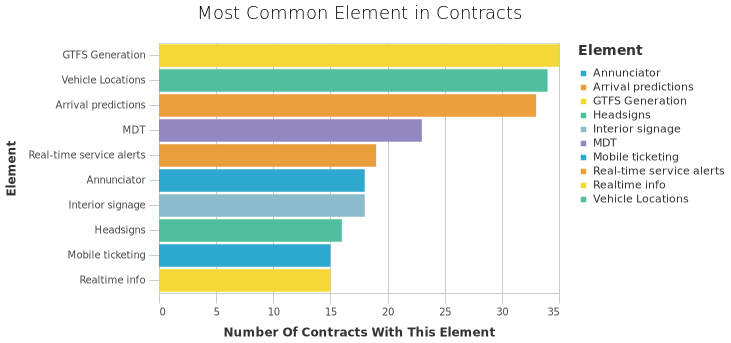

In [85]:
most_used_comps = (
    service_components2.groupby("components_orgs_actually_use")
    .agg({"provider__from_services_": "nunique"})
    .sort_values("provider__from_services_", ascending=False)
    .reset_index()
    .rename(
        columns={
            "components_orgs_actually_use": "Components Used",
            "provider__from_services_": "Count of Organizations",
        }
    )
    .head(10)
)

In [86]:
most_used_comps

,Components Used,Count of Organizations
0,Real-time info,89
1,Scheduling (Fixed-route),81
2,GTFS generation,79
3,Cash Farebox,76
4,Arrival predictions,73
5,AVL Software,70
6,Mobile data terminal software,55
7,Annunciator,52
8,Headsigns,50
9,APC Software,48


In [87]:
utils.basic_bar_chart(
    most_used_comps,
    "Count of Organizations",
    "Components Used",
    "Components Used",
    "Most Popular Components Organizations Use",
)

alt.Chart(...)

## Components with the most products to choose from
***

* Looking at the vendor that is the most popular by component. 
    * AKA which vendor has the most unique customers for a particular component.
* GMV Syncromatics Inc is the most frequent vendor - 7 out of the 27 components.

In [88]:
comp_most_products = (
    service_components2.groupby(
        ["components_orgs_actually_use", "product"]
    )
    .agg({"provider__from_services_": "nunique"})
    .rename(columns={"provider__from_services_": "Number of Customers"})
    .reset_index()
)

In [89]:
comp_most_products2 = (
    comp_most_products.groupby("components_orgs_actually_use")
    .agg({"product": "nunique"})
    .reset_index()
    .sort_values("product", ascending=False)
    .rename(
        columns={
            "components_orgs_actually_use": "Components Used",
            "product": "Total Unique Products",
        }
    )
    .head(10)
)

In [90]:
utils.basic_bar_chart(
    comp_most_products2,
    "Total Unique Products",
    "Components Used",
    "Components Used",
    "Components with the most Products Available",
)

alt.Chart(...)

## Vendor x Component (Used)
***

### Look at the vendors with the most customers by component
***

In [93]:
service_components2.head(1)

,name,services,components_orgs_actually_use,vendor__from_product_,parent_organization__from_vendor___from_product_,provider__from_services_,product,all_components_in_product,contained
0,"GET Bus, GET Bus On Demand-Genfare Farebox (Unspecified)-Cash Farebox","GET Bus,GET Bus On Demand",Cash Farebox,Genfare,N/A,Golden Empire Transit District,Genfare Farebox (Unspecified),Cash Farebox,True


In [94]:
vendor_comp = (
    service_components2.groupby(
        ["components_orgs_actually_use", "vendor__from_product_"]
    )
    .agg({"provider__from_services_": "nunique"})
    .rename(columns={"provider__from_services_": "Number of Customers"})
    .reset_index()
)

In [109]:
vendor_comp.sort_values(['components_orgs_actually_use','Number of Customers'])

,components_orgs_actually_use,vendor__from_product_,Number of Customers
0,APC Sensors,UTA,1
2,APC Software,Centum Adetel,1
4,APC Software,Conduent Inc,1
5,APC Software,Connexionz Inc.,1
7,APC Software,"Dilax Inc.,INIT SE",1
8,APC Software,DoubleMap Inc.,1
10,APC Software,"GMV Syncromatics Inc,Dilax Inc.",1
11,APC Software,Hanover Displays Ltd,1
14,APC Software,"Iris Inc.,Dilax Inc.",1
15,APC Software,N/A,1


In [96]:
# Only keep the vendor with a particular component that is most popular.
# https://stackoverflow.com/questions/43899886/how-do-i-just-keep-the-rows-with-the-maximum-value-in-a-column-for-items-of-the
vendor_comp2 = vendor_comp.loc[
    vendor_comp.groupby("components_orgs_actually_use")["Number of Customers"].idxmax()
].rename(
    columns={
        "components_orgs_actually_use": "Component",
        "vendor__from_product_": "Most Frequent Vendor",
    }
)

In [97]:
len(vendor_comp2)

26

In [98]:
# Look at the vendors with the most customers
vendor_comp2

,Component,Most Frequent Vendor,Number of Customers
0,APC Sensors,UTA,1
17,APC Software,UTA,11
20,AVL On-board Computer,Connexionz Inc.,1
31,AVL Software,GMV Syncromatics Inc,16
51,Alerts Content Management System,GMV Syncromatics Inc,7
68,Annunciator,GMV Syncromatics Inc,11
84,Arrival predictions,GMV Syncromatics Inc,16
92,Cash Farebox,Genfare,49
97,Contactless Payment Validators,Token Transit,2
98,Fare card system,Sacramento Area Council of Governments,5


In [103]:
#Filter out for one
vendor_comp2 = vendor_comp2[vendor_comp2['Number of Customers'] != 1] 

In [104]:
vendor_comp2["Most Frequent Vendor"].value_counts()

GMV Syncromatics Inc                      7
Genfare                                   2
Token Transit                             2
Trillium Inc.                             2
UTA                                       1
Sacramento Area Council of Governments    1
Hanover Displays Ltd                      1
TransTrack Solutions Group                1
Elavon                                    1
Transit App Inc.                          1
N/A                                       1
Cubic                                     1
Microsoft                                 1
Name: Most Frequent Vendor, dtype: int64

In [105]:
vendor_top_comps =  utils.value_counts_df(vendor_comp2, "Most Frequent Vendor").head(5).rename(columns ={'index':'Vendor','Most Frequent Vendor':'# of Products'})

In [106]:
vendor_top_comps.style.hide(axis = 'index').set_properties(**{"background-color": "white"}).set_table_styles(
    [dict(selector="th", props=[("text-align", "center")])]
).set_properties(
    **{"text-align": "center"}
)

Vendor,# of Products
GMV Syncromatics Inc,7
Genfare,2
Token Transit,2
Trillium Inc.,2
UTA,1


### Which vendors have the most components available for purchase
***
* Some different vendors are mixed together. Not sure how to address this. 
    * Dilax Inc., INIT SE. 
    * Optibus,GMV Syncromatics Inc
    * Hanover Displays Ltd,Clever Devices Ltd.	
    * and more..


In [ ]:
# First group vendors by products and the # of components in the product - use MAX
vendor_most_comp = (
    service_components3.groupby(["vendor__from_product_", "product"])
    .agg({"number_of_components_avail": "max"})
    .reset_index()
)

In [ ]:
# Second, group by vendor and sum up all the components among all their products.
vendor_most_comp = (
    vendor_most_comp.groupby(["vendor__from_product_"])
    .agg({"number_of_components_avail": "sum"})
    .reset_index()
    .sort_values("number_of_components_avail", ascending=False)
    .rename(
        columns={
            "vendor__from_product_": "Vendor",
            "number_of_components_avail": "Total Components",
        }
    )
)

In [ ]:
# Take out N/A?
vendor_most_comp = vendor_most_comp.loc[vendor_most_comp["Vendor"] != "N/A"]

In [ ]:
vendor_most_comp.head(5)

### Which vendors have the most customers?
***

In [ ]:
vendors_most_customers = service_components2.loc[
    service_components2["vendor__from_product_"] != "N/A"
]

In [ ]:
vendors_most_customers = (
    vendors_most_customers.groupby("vendor__from_product_")
    .agg({"provider__from_services_": "nunique"})
    .sort_values("provider__from_services_", ascending=False)
    .reset_index()
    .head(10)
    .rename(
        columns={
            "vendor__from_product_": "Vendor",
            "provider__from_services_": "Number of Customers",
        }
    )
)

In [ ]:
utils.basic_bar_chart(
    vendors_most_customers,
    "Number of Customers",
    "Vendor",
    "Vendor",
    "Vendor with the most Customers",
)

## Parent Company x Vendor
***

In [ ]:
# As there are a lot of N/A for the parent org, filter out N/A
parent_comp = service_components2.loc[
    service_components2["parent_organization__from_vendor___from_product_"] != "N/A"
]

In [ ]:
f"only {len(parent_comp)} rows left after filtering out for populated parent organization from vendor"

In [ ]:
parent_comp.parent_organization__from_vendor___from_product_.nunique()

In [ ]:
parent_comp.head(1)

In [ ]:
parent_comp.groupby(["parent_organization__from_vendor___from_product_"]).agg(
    {"provider__from_services_": "nunique"}
)

## Looking into 5 categories more in depth
***

In [ ]:
# Drop duplicate vendor-organization-product
in_depth = service_components2.drop_duplicates(
    subset=[
        "vendor__from_product_",
        "provider__from_services_",
        "product",
        "all_components_in_product",
    ]
)

In [ ]:
len(in_depth)

In [ ]:
service_components2.columns

In [ ]:
subset_list = [
    "GTFS generation",
    "AVL Software",
    "Mobile ticketing",
    "Real-time info",
    "Scheduling (Fixed-route)",
    "Cash Farebox",
    "Arrival predictions"
]

In [ ]:
# new dataframe with only the components in our list
in_depth2 = in_depth[in_depth.components_orgs_actually_use.isin(subset_list)]

In [ ]:
in_depth2 = (in_depth2.groupby(['components_orgs_actually_use','vendor__from_product_'])
             .agg({'provider__from_services_':'nunique'})
             .reset_index()
             .rename(columns = {'components_orgs_actually_use':'Components','vendor__from_product_':'Vendor','provider__from_services_':'Total Customers'}) 
            )

for i in subset_list:
    utils.fancy_bar_chart(
        (in_depth2[(in_depth2.Components == i)])
        .sort_values("Total Customers", ascending=False)
        .head(5),
        "Total Customers",
        "Vendor",
        "Total Customers",
        f"Top 5 Vendors in {i}",
    )

## Agency Info - Most "Popular" Vendors in  Real Time Info Category
***
* In response to [Lauren's question](https://docs.google.com/presentation/d/1zOOzmIuKzGoioBAbwL0Ojeq-zCOsaCyxwUbn-WPkkt8/edit#slide=id.g11c26f6eed0_0_13)
* Using Service Components data set, since it's more accurate.

In [ ]:
# Only search for vendors in the chart Lauren referenced.
agency1 = service_components2[
    service_components2["vendor__from_product_"].str.contains("Cubic")
    | service_components2["vendor__from_product_"].str.contains("Connexionz")
    | service_components2["vendor__from_product_"].str.contains("Swiftly")
    | service_components2["vendor__from_product_"].str.contains("DoubleMap")
    | service_components2["vendor__from_product_"].str.contains("Bishop Peak")
] 

In [ ]:
agency1.components_orgs_actually_use.unique()

In [ ]:
#Only search for real time
agency1=agency1[agency1['components_orgs_actually_use'] == 'Real-time info'] 

In [ ]:
len(agency1)

In [ ]:
f"{agency1.vendor__from_product_.nunique()} different vendor combinations"

In [ ]:
# Shorten vendor group to only the 5 vendors we care about
# https://stackoverflow.com/questions/61811137/based-on-partial-string-match-fill-one-data-frame-column-from-another-dataframe
vendors_list = [
    "Connexionz Inc.",
    "Cubic",
    "Bishop Peak Technologies",
    "DoubleMap Inc.",
    "Swiftly Inc.",
]

In [ ]:
# Fill in vendor from product column with various combinations of vendors.
agency1["vendor_use"] = agency1["vendor__from_product_"].apply(
    lambda x: "".join([part for part in vendors_list if part in x])
)

In [ ]:
len(agency1)

In [ ]:
# Group by vendor and provider
agency_group = (
    agency1.groupby(["vendor_use", "provider__from_services_"])
    .agg({"services": "nunique"})
    .reset_index()
)

In [ ]:
# replace providers as this is the column we merge on with Cal ITP's data later.
agency_group["provider__from_services_"] = agency_group[
    "provider__from_services_"
].replace(
    {
        " Davis": "University of California, Davis",
        " Berkeley": "University of California, Berkeley",
        "City of Fairfield": "City of Fairfield, California",
        "Gold Coast Transit": "Gold Coast Transit District",
        "OmniTrans": "Omnitrans",
        "Placer County": "County of Placer",
        "Tuolumne County Transit Agency": "Tuolumne County Transit",
        "Nevada County": "Nevada County Transit Services",
        "Los Angeles": "City of Los Angeles",
        " Solano County Transit": "Solano County Transit",
        "City of Visalia ": "City of Visalia",
        'Tulare County Regional Transit Agency':'Tulare County Area Transit',
        'County of Sonoma ': 'County of Sonoma',
       'Kern County': 'Kern Regional Transit',
        'Stanislaus Regional Transit Authority': 'Stanislaus County dba: Stanislaus Regional Transit',
        "Los Angeles County Metropolitan Transportation Authority": "Los Angeles County Metropolitan Transportation Authority ",
    }
)

In [ ]:
# Merge in NTD data from Cal ITP airtable
ntd = to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}NTD agency info-Grid view.csv"))

In [ ]:
#agency_group.sort_values(by = 'provider__from_services_').provider__from_services_.unique()

In [ ]:
#ntd.sort_values(by = 'agency_name').agency_name.unique()

In [ ]:
merge1 = pd.merge(
    agency_group,
    ntd,
    left_on="provider__from_services_",
    right_on="agency_name",
    how="left",
    indicator=True,
)

In [ ]:
merge1._merge.value_counts()

In [ ]:
merge1.loc[merge1['_merge']=='left_only']

In [ ]:
# Fill in null values for columns to group on
merge1["reporting_module"].fillna(value="N/A", inplace=True)
merge1["service_area_pop"].fillna(value=0, inplace=True)

In [ ]:
len(merge1)

In [ ]:
p75 = merge1.service_area_pop.quantile(0.75).astype(float)
p25 = merge1.service_area_pop.quantile(0.25).astype(float)
p50 = merge1.service_area_pop.quantile(0.50).astype(float)

In [ ]:
# Function to give a rough estimate whether an agency is small, medium, or large based on the service population column
def pop_served(row):
    if (row.service_area_pop > p25) and (row.service_area_pop < p50):
        return "Small"
    elif (row.service_area_pop > p50) and (row.service_area_pop < p75):
        return "Medium"
    elif row.service_area_pop == 0:
        return "No Info"
    else:
        return "Large"

In [ ]:
merge1["agency_size_based_on_service_population"] = merge1.apply(
    lambda x: pop_served(x), axis=1
)

In [ ]:
# Double check
merge1[
    [
        "provider__from_services_",
        "service_area_pop",
        "agency_size_based_on_service_population",
    ]
].sample(3)

In [ ]:
agency_info = merge1[
    [
        "vendor_use",
        "provider__from_services_",
        "service_area_pop",
        "agency_size_based_on_service_population",
        "reporter_type",
        "primary_uza",
        "uza_name",
        "voms_do",
        "voms_pt",
        "total_voms",
    ]
]

In [ ]:
agency_info = agency_info.fillna("N/A")

In [ ]:
agency_info.sample(2)

In [ ]:
# Write to Excel
with pd.ExcelWriter(f"{GCS_FILE_PATH}agency_vendor_question.xlsx") as writer:
    agency_info.to_excel(writer, sheet_name="Full_Data", index=False)